#Set up

**Variables of Interest:**

Quality Rating

Location of Plot (Row, Col)

Company

Time of Rating (Year and Month)

Rater

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
df = pd.read_csv('gdrive/My Drive/OxbridgeEconomics/quality_nj2.csv')

Mounted at /content/gdrive


In [2]:
def month_to_int(month):
  if month.lower() == 'jan': return 0
  elif month.lower() == 'feb': return 1
  elif month.lower() == 'mar': return 2
  elif month.lower() == 'apr': return 3
  elif month.lower() == 'may': return 4
  elif month.lower() == 'jun': return 5
  elif month.lower() == 'jul': return 6
  elif month.lower() == 'aug': return 7
  elif month.lower() == 'sep': return 8
  elif month.lower() == 'oct': return 9
  elif month.lower() == 'nov': return 10
  elif month.lower() == 'dec': return 11
df['MONTH_INT'] = df['MONTH'].apply(month_to_int)
df['TIME'] = (df['YEAR']-2018)*12 + df['MONTH'].apply(month_to_int)
#df.groupby(['TIME']).mean().head()

#Initial Observations

Since we want to determine an objective way to measure the quality, the quality rating is likely a good place to start. We begin by exploring its distribution interaction with other variables.

It takes an integer value from 1-9 inclusive, and appears to be approximately normally distributed, with a mean somewhere between 4 and 5.

The Plot ID contains a significant amount of mutual information with quality, but this is to be expected due to the large number of different plots.

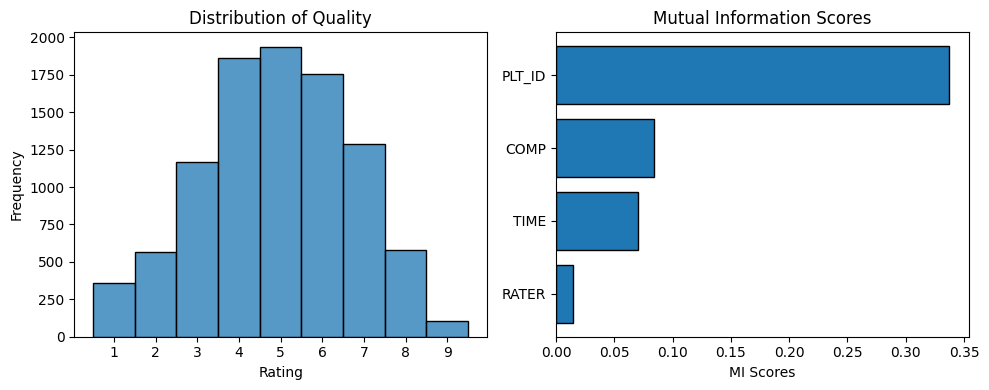

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Plot histogram
sns.histplot(data=df, x='QUALITY', bins=range(1, 11), kde=False, ax=ax1)
ax1.set_xlabel('Rating')
ax1.set_ylabel('Frequency')
ax1.set_xticks(np.arange(1, 10) + 0.5)
ax1.set_xticklabels(range(1, 10))
ax1.set_title('Distribution of Quality')
# Plot mutual information scores
df_info = df.copy()
y = df_info.pop("QUALITY")
for colname in ['RATER', 'COMP']:
    df_info[colname], _ = df_info[colname].factorize()
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
mi_scores = make_mi_scores(df_info[['PLT_ID', 'TIME', 'RATER', 'COMP']], y)
def plot_mi_scores(scores, ax):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    ax.barh(width, scores, edgecolor="black")
    ax.set_yticks(width)
    ax.set_yticklabels(ticks)
    ax.set_title("Mutual Information Scores")
    ax.set_xlabel("MI Scores")
plot_mi_scores(mi_scores, ax2)
plt.tight_layout()
plt.show()

For the relationship between quality and plot, from the heatmap, it is not clear if there are certain geospatial effects affecting the quality of the turfgrass, (e.g. a certain area might be better irrigated), as the impact of such an effect would not be obvious unless the magnitude of the effect is huge.

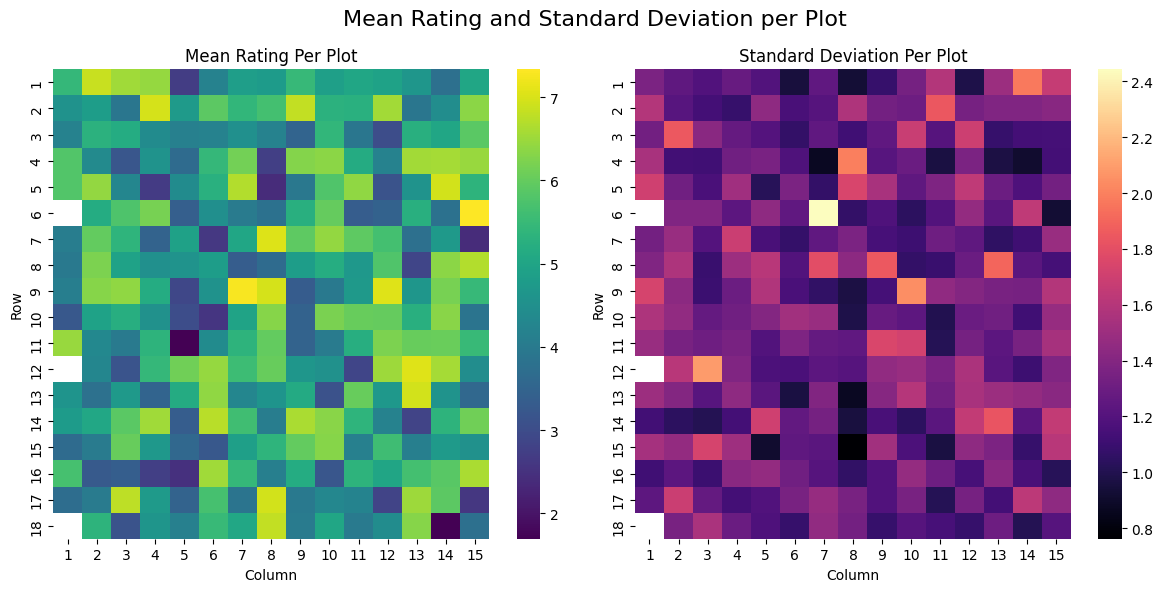

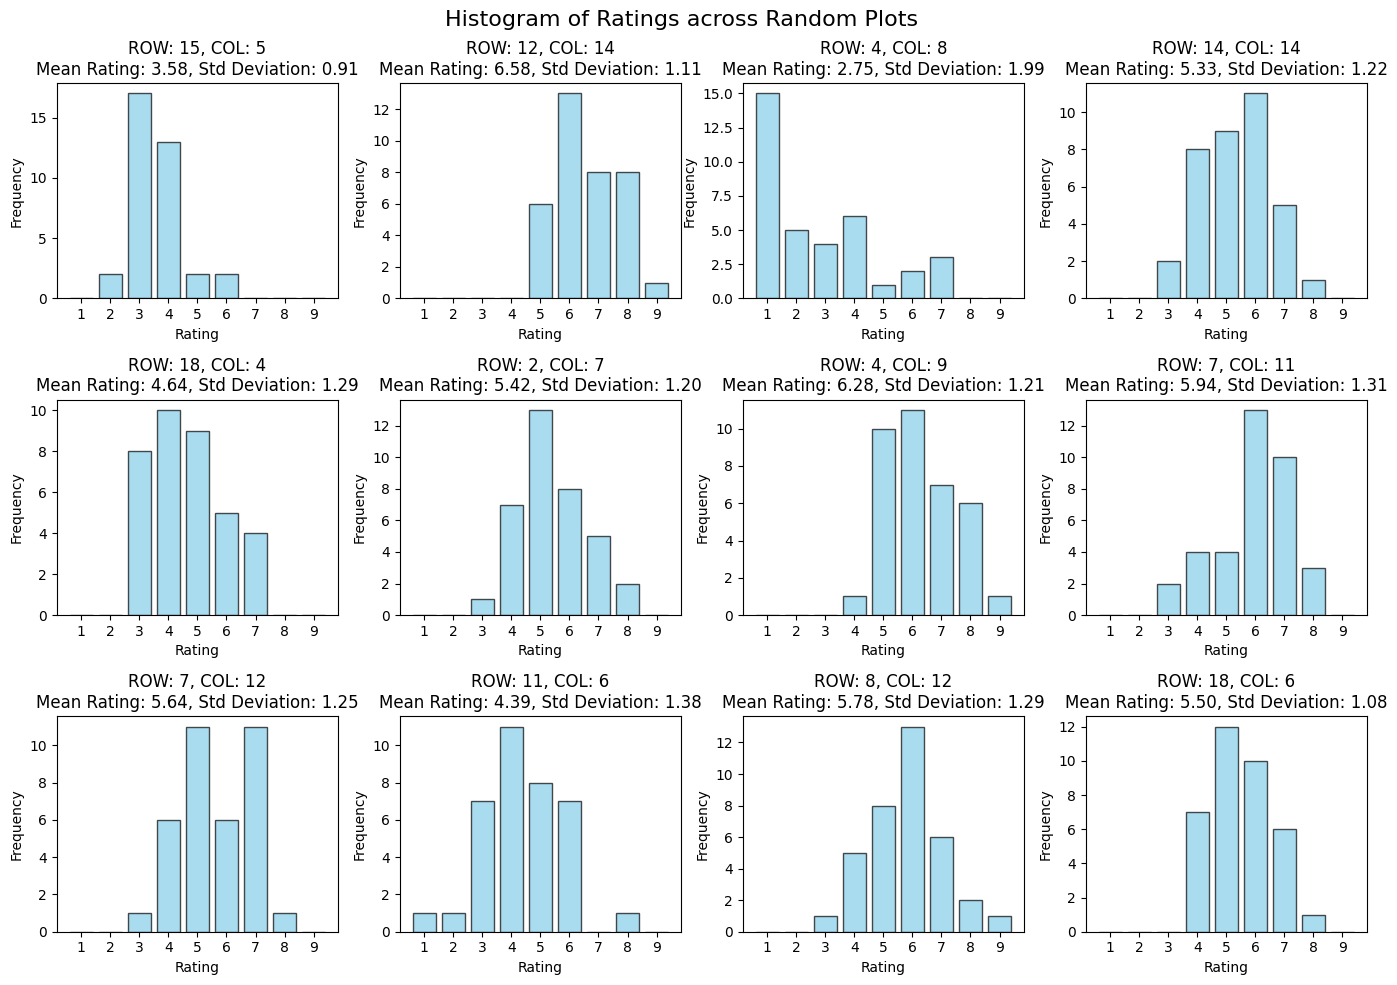

In [108]:
mean_df = df.pivot_table(values='QUALITY', index='ROW', columns='COL', aggfunc='mean')
std_df = df.pivot_table(values='QUALITY', index='ROW', columns='COL', aggfunc='std')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Mean Rating and Standard Deviation per Plot', fontsize=16)
ax1 = axes[0]
sns.heatmap(mean_df, cmap='viridis', annot=False, ax=ax1)
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
ax1.set_title('Mean Rating Per Plot')
ax2 = axes[1]
sns.heatmap(std_df, cmap='magma', annot=False, ax=ax2)
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
ax2.set_title('Standard Deviation Per Plot')
plt.tight_layout()
plt.show()
# Select 12 random plot IDs
random_plot_ids = random.sample(list(df['PLT_ID'].unique()), 12)
# Create a figure with 12 subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 10))
fig.suptitle('Histogram of Ratings across Random Plots', fontsize=16)
# Iterate over the random plot IDs and plot histograms
for i, plot_id in enumerate(random_plot_ids):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    # Filter data for the current plot ID
    plot_data = df[df['PLT_ID'] == plot_id]
    # Get the ROW and COL values for the current plot ID
    row_value = plot_data['ROW'].values[0]
    col_value = plot_data['COL'].values[0]
    # Calculate mean and standard deviation
    mean_rating = plot_data['QUALITY'].mean()
    std_rating = plot_data['QUALITY'].std()
    # Plot histogram on the current subplot
    ax.hist(plot_data['QUALITY'], bins=range(1, 11), color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.8)
    ax.set_title(f'ROW: {row_value}, COL: {col_value}\nMean Rating: {mean_rating:.2f}, Std Deviation: {std_rating:.2f}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(1, 10) + 0.5)
    ax.set_xticklabels(range(1, 10))
plt.tight_layout()
plt.show()

Quality variation across different companies.

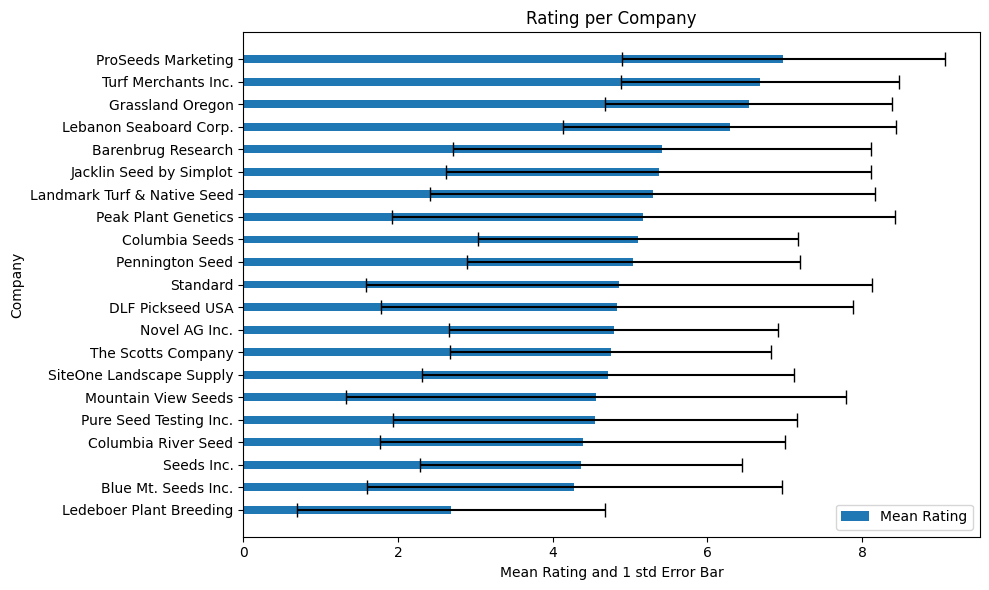

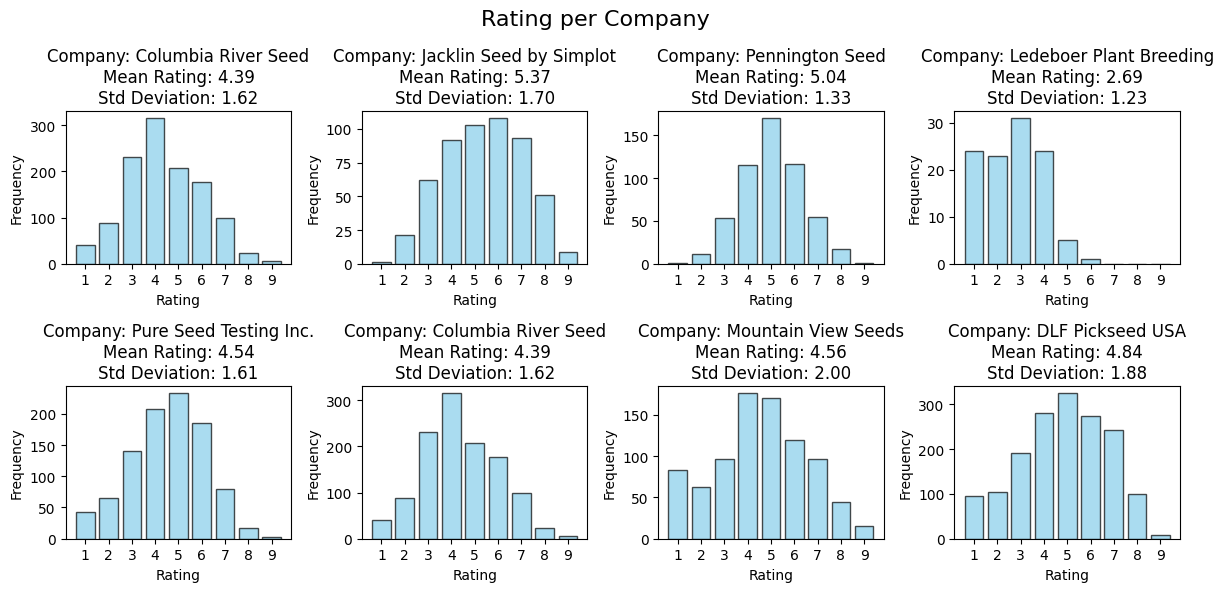

In [109]:
mean_ratings = df.groupby('COMP')['QUALITY'].mean()
std_ratings = df.groupby('COMP')['QUALITY'].std()
mean_ratings_sorted = mean_ratings.sort_values(ascending=True)
std_ratings_sorted = std_ratings.loc[mean_ratings_sorted.index]*1.62
companies = mean_ratings_sorted.index
positions = np.arange(len(companies))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(positions, mean_ratings_sorted, bar_width, label='Mean Rating')
ax.errorbar(mean_ratings_sorted, positions, xerr=std_ratings_sorted, fmt='none', color='black', capsize=5)
ax.set_yticks(positions)
ax.set_yticklabels(companies)
ax.set_xlabel('Mean Rating and 1 std Error Bar')
ax.set_ylabel('Company')
ax.set_title('Rating per Company')
ax.legend()
plt.tight_layout()
plt.show()

random_companies = np.random.choice(df['COMP'].unique(), size=8, replace=False)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.suptitle('Rating per Company', fontsize=16)
for i, company in enumerate(random_companies):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    # Filter data for the current company
    company_data = df[df['COMP'] == company]
    # Calculate mean rating and standard deviation
    mean_rating = company_data['QUALITY'].mean()
    std_rating = company_data['QUALITY'].std()
    # Plot histogram on the current subplot
    ax.hist(company_data['QUALITY'], bins=range(1, 11), color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.8)
    ax.set_title(f'Company: {company}\nMean Rating: {mean_rating:.2f}\nStd Deviation: {std_rating:.2f}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(1, 10) + 0.5)
    ax.set_xticklabels(range(1, 10))
plt.tight_layout()
plt.show()

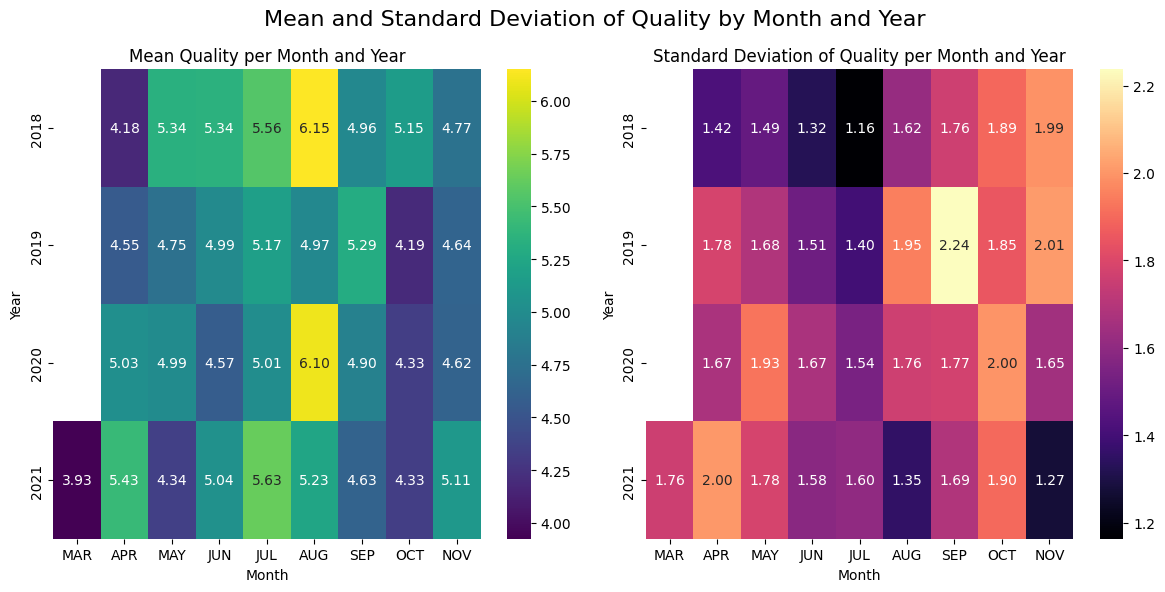

In [110]:
mean_df = df.pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='mean')
std_df = df.pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='std')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Mean and Standard Deviation of Quality by Month and Year', fontsize=16)
ax1 = axes[0]
sns.heatmap(mean_df, cmap='viridis', annot=True, fmt='.2f', cbar=True, ax=ax1)
ax1.set_xlabel('Month')
ax1.set_xticks(ticks=np.arange(9)+0.5)
ax1.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
ax1.set_ylabel('Year')
ax1.set_title('Mean Quality per Month and Year')
ax2 = axes[1]
sns.heatmap(std_df, cmap='magma', annot=True, fmt='.2f', cbar=True, ax=ax2)
ax2.set_xlabel('Month')
ax2.set_xticks(ticks=np.arange(9)+0.5)
ax2.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
ax2.set_ylabel('Year')
ax2.set_title('Standard Deviation of Quality per Month and Year')
plt.tight_layout()
plt.show()

Time and Raters are closely linked together, as there is often only 1 rater for a specific month. This makes it hard to deduce the impact of a specific rater being biased towards giving low ratings, as opposed to just poor turfgrass quality throughout the whole month.

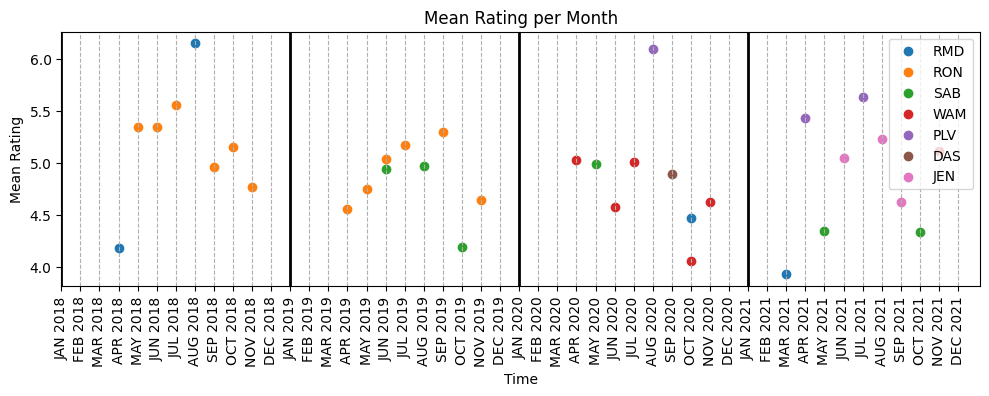

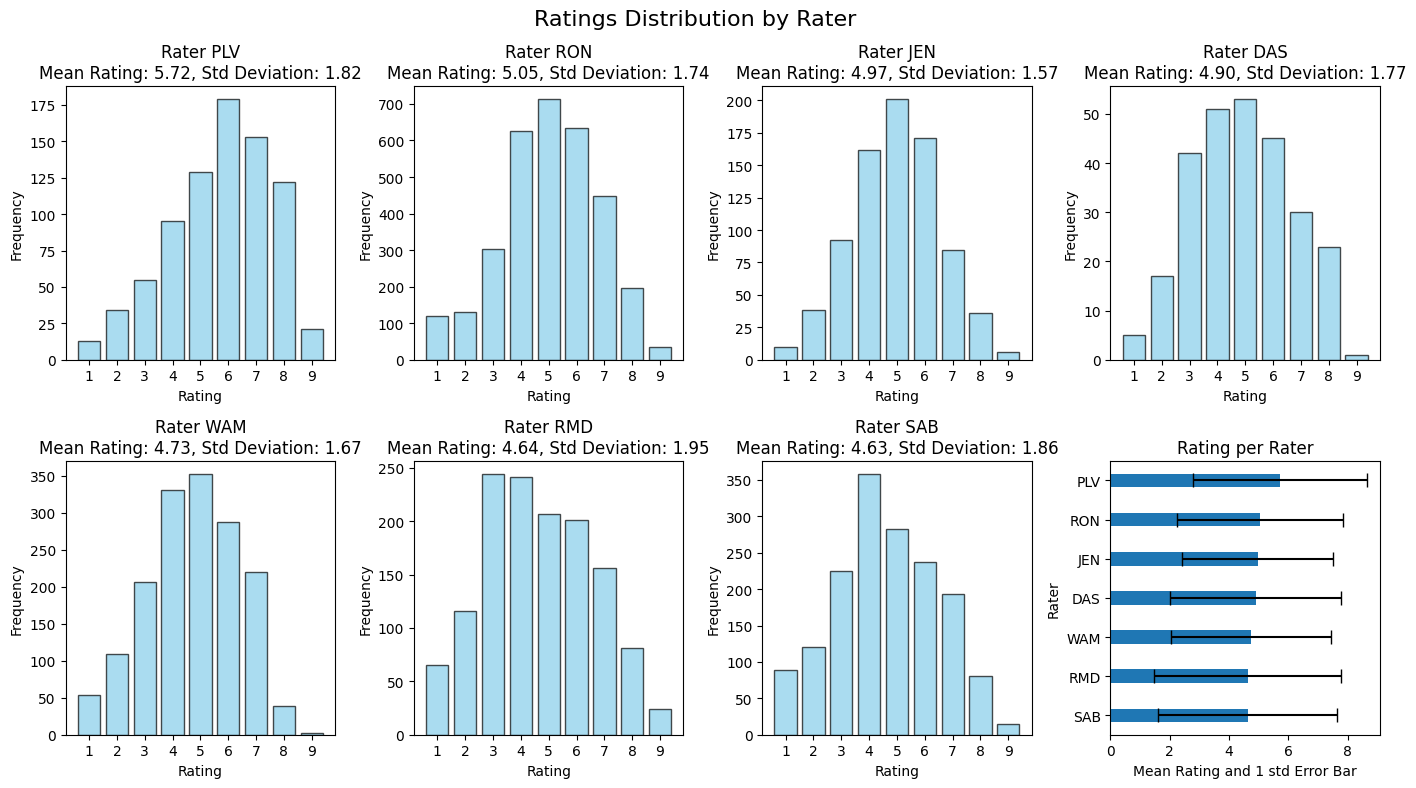

In [111]:
average_ratings = df.groupby(['TIME', 'RATER'])['QUALITY'].mean().reset_index()
plt.figure(figsize=(10, 3.5))
for rater in average_ratings['RATER'].unique():
    data = average_ratings[average_ratings['RATER'] == rater]
    plt.scatter(data['TIME'], data['QUALITY'], label=rater)
plt.xlabel('Time')
plt.ylabel('Mean Rating')
plt.title('Mean Rating per Month')
plt.legend()
plt.tight_layout()
plt.xticks(range(48), [['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'][x%12]+" "+str(2018+x//12) for x in range(48)], rotation=90)  # Set text labels and properties.
plt.gca().xaxis.grid(True, which='major', linestyle='--')
for year in range(2018, 2022): plt.axvline(x=(year - 2018) * 12, color='black', linewidth=2)
plt.show()
raters = df.groupby('RATER')['QUALITY'].mean().sort_values(ascending=False).index
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
fig.suptitle('Ratings Distribution by Rater', fontsize=16)
for i, rater in enumerate(raters):
    ax = axes[i // 4, i % 4]
    data = df[df['RATER'] == rater]['QUALITY']
    ax.hist(data, bins=range(1, 11), color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.8)
    ax.set_xlabel('Rating')
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(1.5, 10.5, 1))
    ax.set_xticklabels(range(1, 10))
    # Calculate mean and standard deviation
    mean_rating = data.mean()
    std_rating = data.std()
    # Set the subplot title to include the rater, mean, and standard deviation
    ax.set_title(f'Rater {rater}\nMean Rating: {mean_rating:.2f}, Std Deviation: {std_rating:.2f}')
mean_ratings = df.groupby('RATER')['QUALITY'].mean()
std_ratings = df.groupby('RATER')['QUALITY'].std()
mean_ratings_sorted = mean_ratings.sort_values(ascending=True)
std_ratings_sorted = std_ratings.loc[mean_ratings_sorted.index]*1.62
raters = mean_ratings_sorted.index
positions = np.arange(len(raters))
bar_width = 0.35
ax = axes[1, 3]
bars = ax.barh(positions, mean_ratings_sorted, bar_width, label='Mean Rating')
ax.errorbar(mean_ratings_sorted, positions, xerr=std_ratings_sorted, fmt='none', color='black', capsize=5)
ax.set_yticks(positions)
ax.set_yticklabels(raters)
ax.set_xlabel('Mean Rating and 1 std Error Bar')
ax.set_ylabel('Rater')
ax.set_title('Rating per Rater')
plt.tight_layout()
plt.show()

#Analysis of Geospatial Effects

We see that each plot is allocated to a specific company throughout the entire time period. This will likely account for a significant portion of the variance between plots.

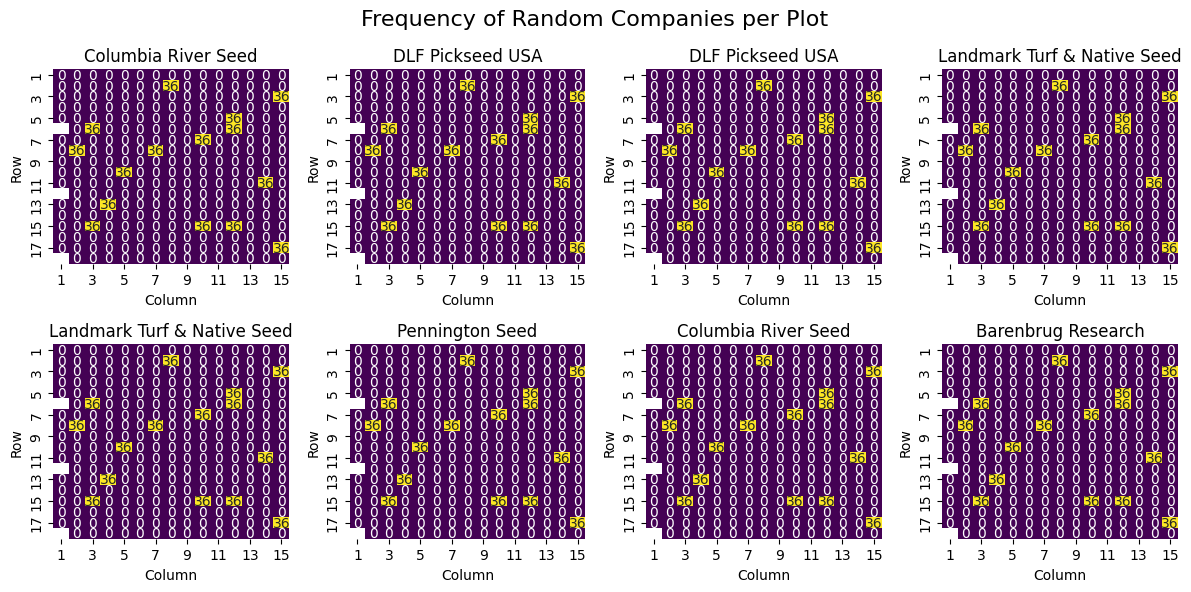

In [112]:
random_companies = np.random.choice(df['COMP'].unique(), size=8, replace=False)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for i, company in enumerate(random_companies):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    company_counts = df.pivot_table(values='COMP', index='ROW', columns='COL', aggfunc=lambda x: (x == specific_company).sum())
    fig.suptitle('Frequency of Random Companies per Plot', fontsize=16)
    sns.heatmap(company_counts, cmap='viridis', annot=True, cbar=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(f'{company}')
plt.tight_layout()
plt.show()

If we want to look for geospatial effects, it may be useful to standardize the plot quality depending on the mean and standard deviation of the company assigned.

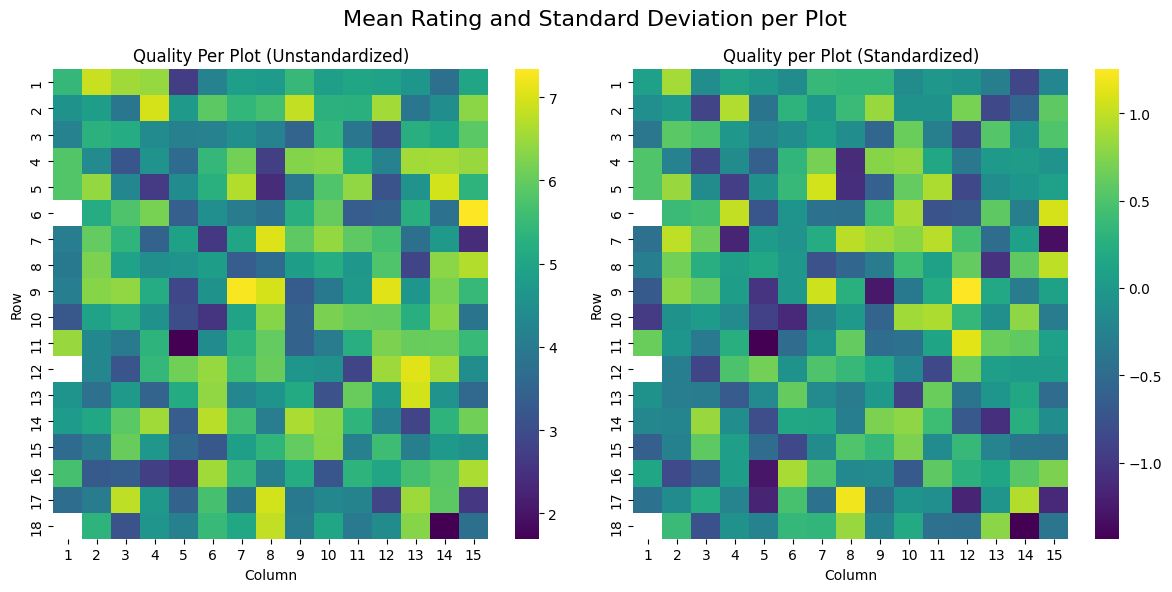

In [113]:
mean_df = df.pivot_table(values='QUALITY', index='ROW', columns='COL', aggfunc='mean')
std_df = df.pivot_table(values='QUALITY', index='ROW', columns='COL', aggfunc='std')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Mean Rating and Standard Deviation per Plot', fontsize=16)
ax1 = axes[0]
sns.heatmap(mean_df, cmap='viridis', annot=False, ax=ax1)
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
ax1.set_title('Quality Per Plot (Unstandardized)')
# Standardized
ax2 = axes[1]
company_stats = df.groupby('COMP')['QUALITY'].agg(['mean', 'std'])
df['STANDARDIZED_QUALITY'] = (df['QUALITY'] - df['COMP'].map(company_stats['mean'])) / df['COMP'].map(company_stats['std'])
heatmap_df = df.pivot_table(values='STANDARDIZED_QUALITY', index='ROW', columns='COL', aggfunc='mean')
sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax2)
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
ax2.set_title('Quality per Plot (Standardized by Company)')
plt.tight_layout()
plt.show()

We observe that if we break it down by specific time, there is likely a geospatial effect. This effect is more clear when the plot is standardized by company.

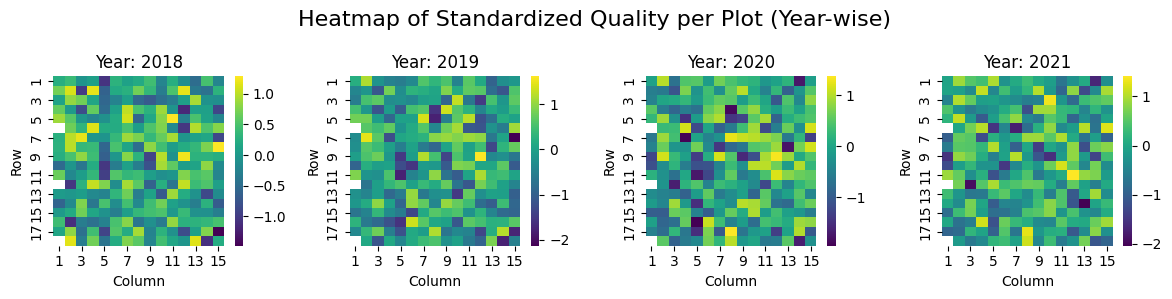

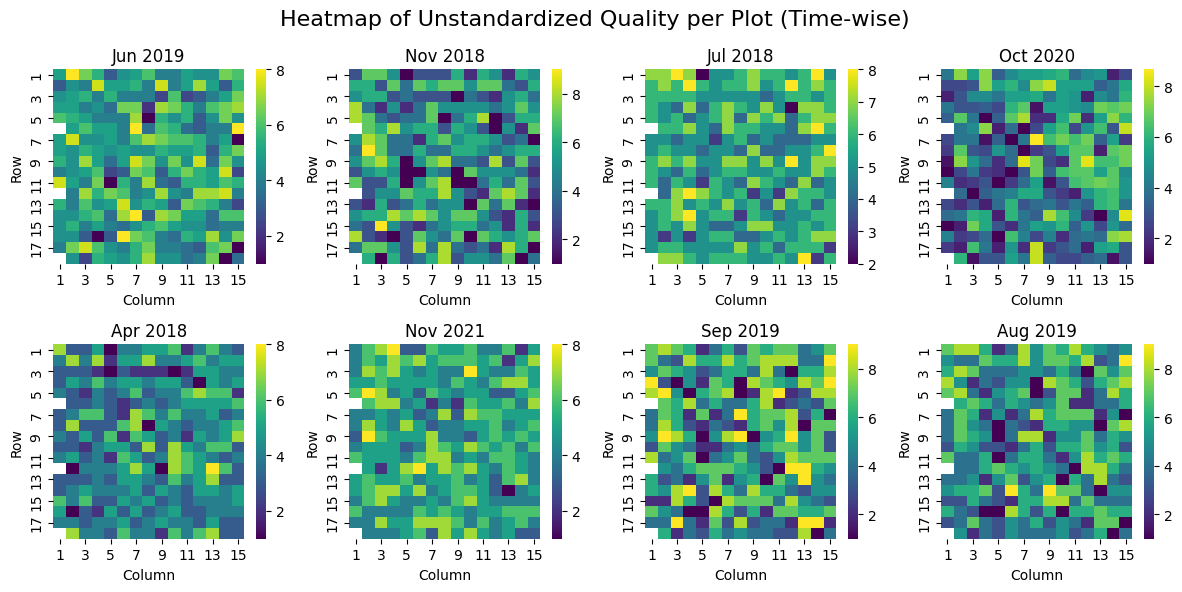

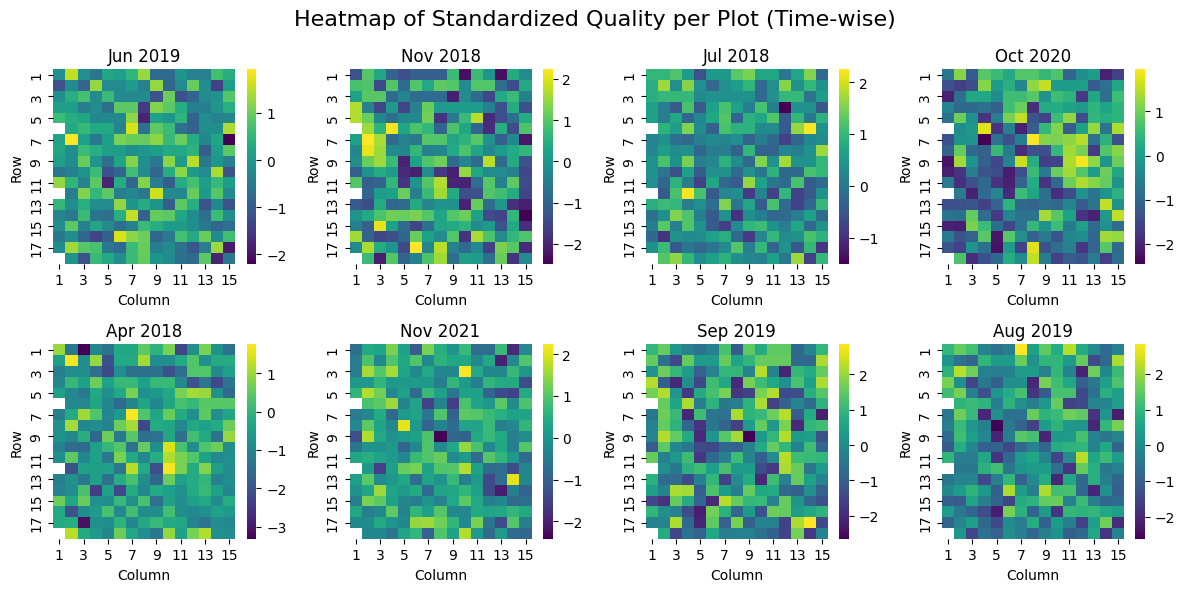

In [119]:
random_times = np.random.choice(df['TIME'].unique(), size=8, replace=False)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.suptitle('Heatmap of Unstandardized Quality per Plot (Time-wise)', fontsize=16)
for i, time in enumerate(random_times):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    time_data = df[df['TIME'] == time]
    heatmap_df = time_data.pivot_table(values='QUALITY', index='ROW', columns='COL', aggfunc='mean')
    sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][time%12]+" "+str(2018+time//12))
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.suptitle('Heatmap of Quality per Plot (Time-wise), Standardized by Company', fontsize=16)
for i, time in enumerate(random_times):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    time_data = df[df['TIME'] == time]
    heatmap_df = time_data.pivot_table(values='STANDARDIZED_QUALITY', index='ROW', columns='COL', aggfunc='mean')
    sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][time%12]+" "+str(2018+time//12))
plt.tight_layout()
plt.show()



Since it may be more useful to look at specific times when accounting for geospatial effects, it may be useful to understand how the performance of specific companies varies across time. The visualization suggests that mean quality of companies is highly correlated between adjacent months, but not as much from year to year.

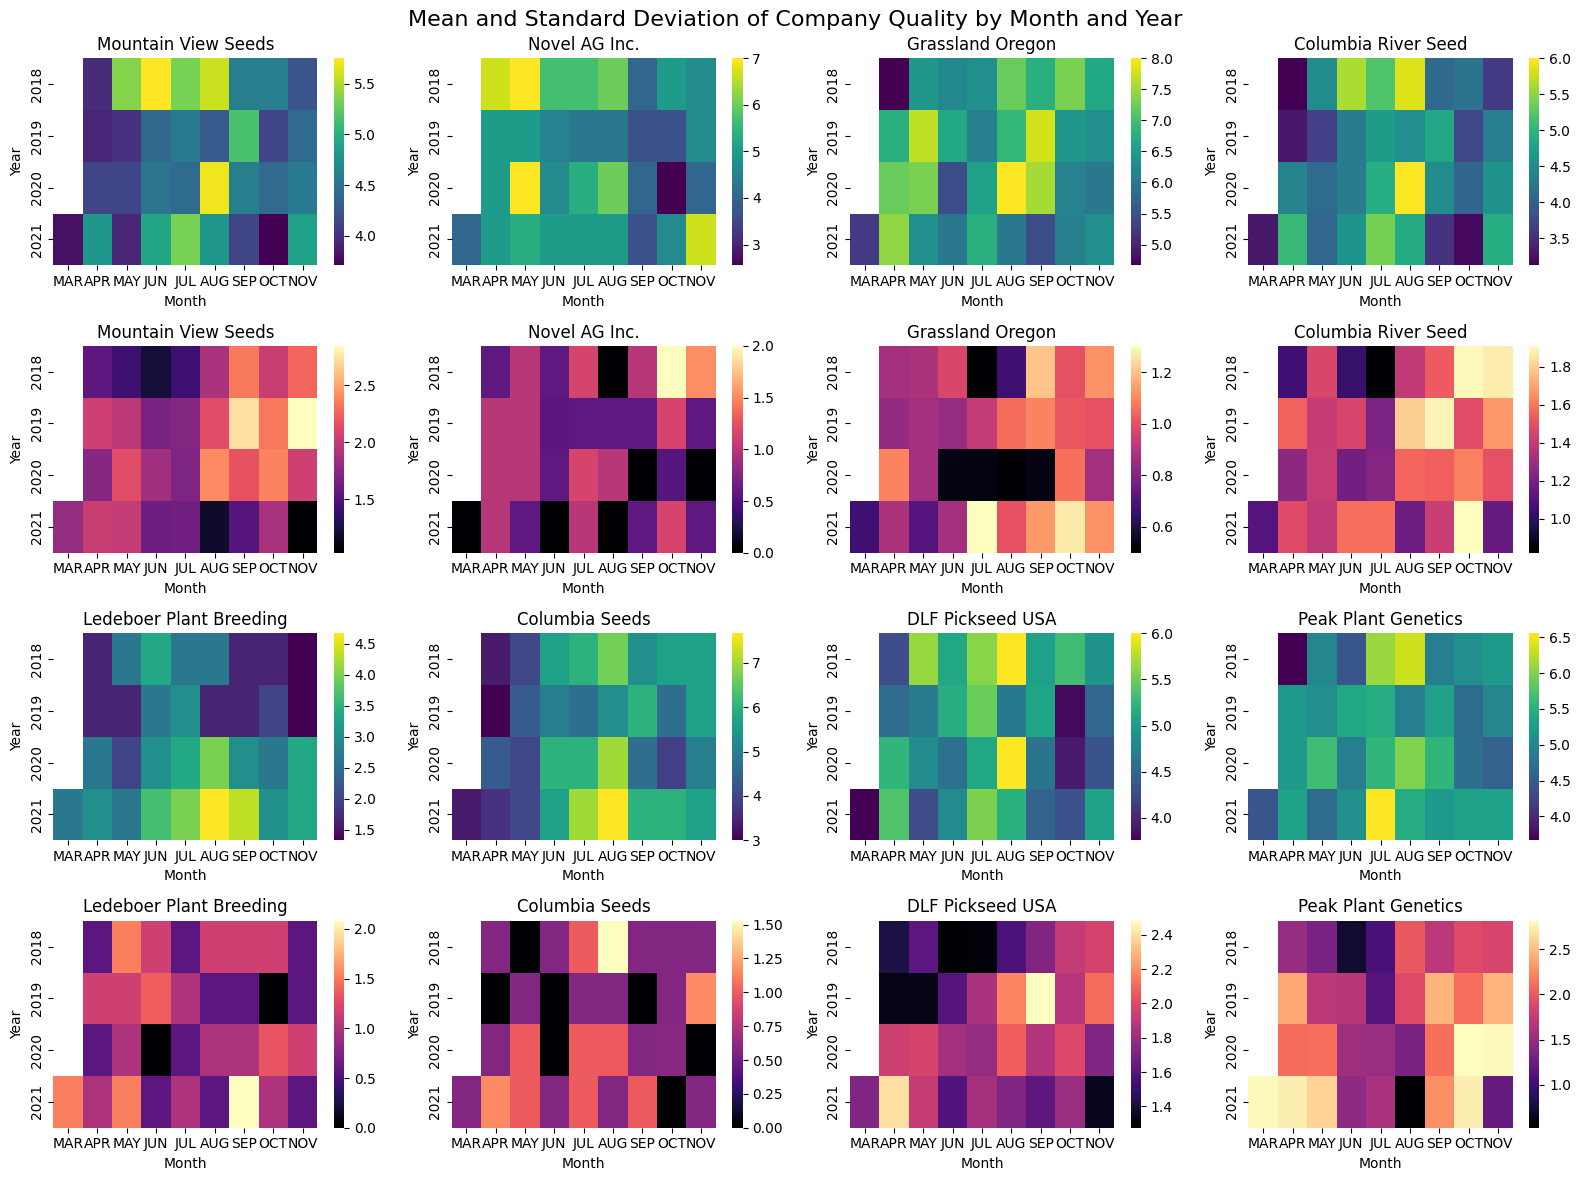

In [11]:
import random
# Randomly select 4 companies
random_companies = np.random.choice(df['COMP'].unique(), size=8, replace=False)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
fig.suptitle('Mean and Standard Deviation of Company Quality by Month and Year', fontsize=16)
# Iterate over the companies
for j in [0,1]:
  for i, company in enumerate(random_companies[4*j:4*j+4]):
      company_data = df[df['COMP'] == company]
      mean_df = company_data.pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='mean')
      std_df = company_data.pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='std')
      # Select the corresponding subplot
      ax1 = axes[0+2*j, i]
      ax2 = axes[1+2*j, i]
      # Plot mean quality
      sns.heatmap(mean_df, cmap='viridis', annot=False, cbar=True, ax=ax1)
      ax1.set_xlabel('Month')
      ax1.set_xticks(ticks=np.arange(9)+0.5)
      ax1.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
      ax1.set_ylabel('Year')
      ax1.set_title(f'{company}')
      # Plot standard deviation
      sns.heatmap(std_df, cmap='magma', annot=False, cbar=True, ax=ax2)
      ax2.set_xlabel('Month')
      ax2.set_xticks(ticks=np.arange(9)+0.5)
      ax2.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
      ax2.set_ylabel('Year')
      ax2.set_title(f'{company}')
plt.tight_layout()
plt.show()


It may be better to consider the mean of the company in that specific month instead (But not use the standard deviation due to the small sample size) to visualize this. It is not clear if this provides any improvement over just standardizing by company.

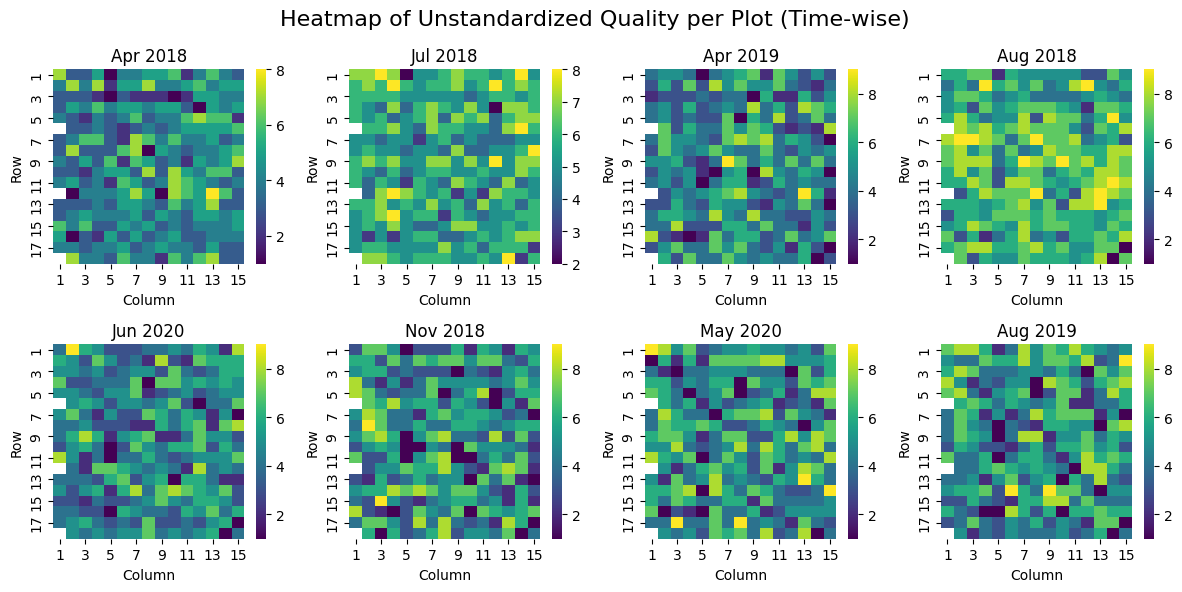

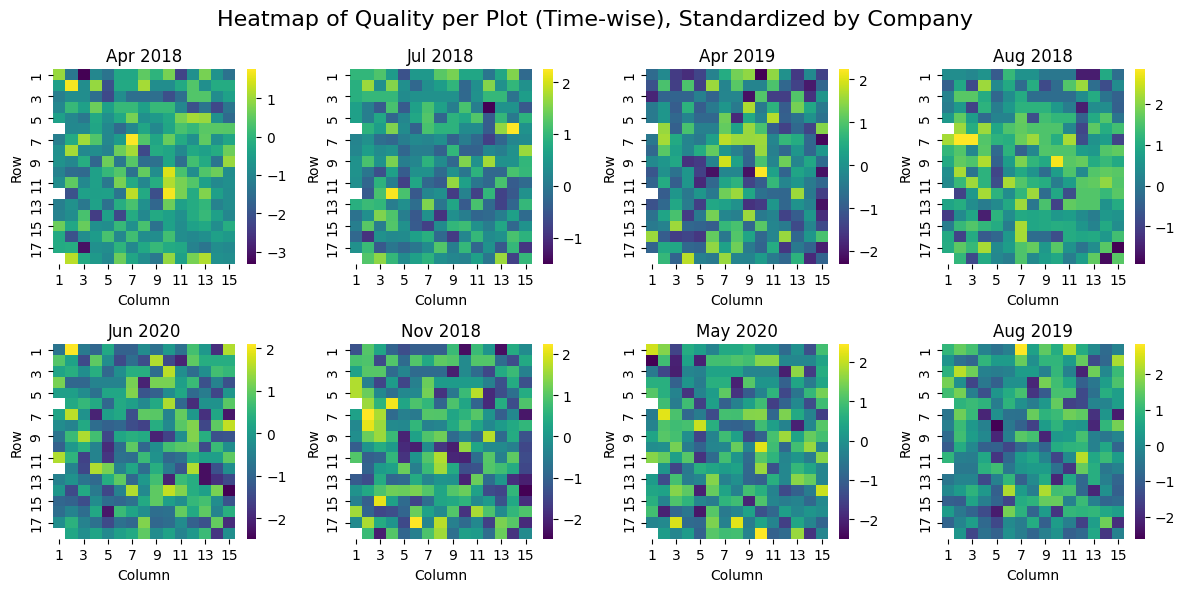

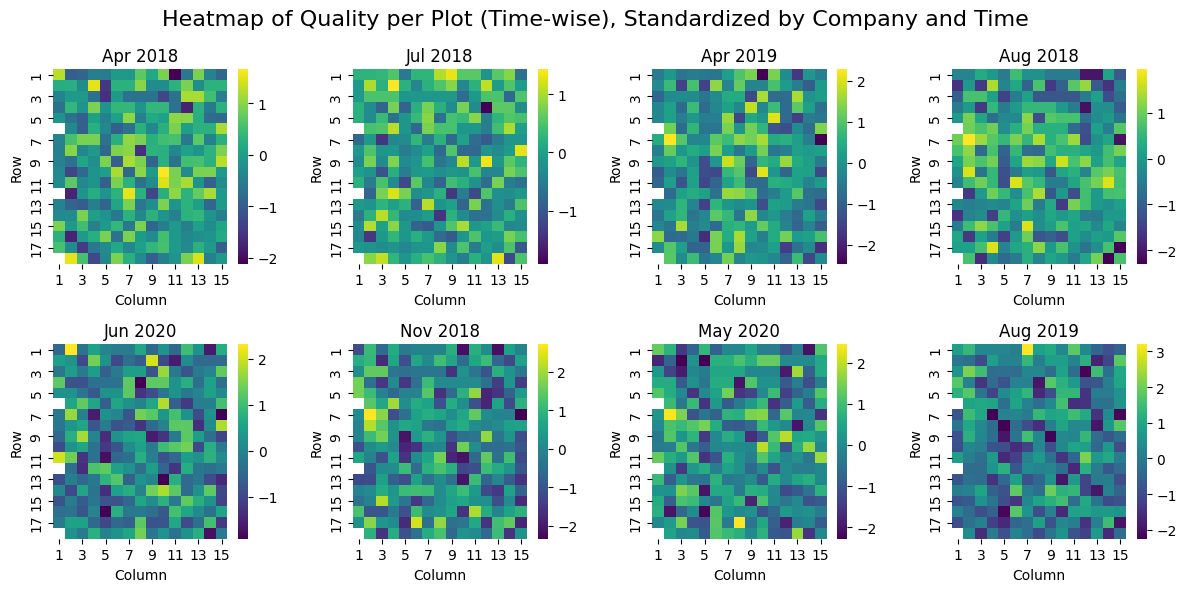

In [145]:
time_company_stats = df.groupby(['COMP', 'TIME'])['QUALITY'].agg(['mean', 'std'])
def get_mean_std(row):
    company = row['COMP']
    time = row['TIME']
    mean = time_company_stats.loc[(company, time), 'mean']
    std = time_company_stats.loc[(company, time), 'std']
    return (mean, std)
df['COMPTIME_STANDARDIZED_QUALITY'] = (df['QUALITY'] - df.apply(get_mean_std, axis=1).map(lambda x: x[0])) / df['COMP'].map(company_stats['std'])
random_times = np.random.choice(df['TIME'].unique(), size=8, replace=False)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.suptitle('Heatmap of Unstandardized Quality per Plot (Time-wise)', fontsize=16)
for i, time in enumerate(random_times):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    time_data = df[df['TIME'] == time]
    heatmap_df = time_data.pivot_table(values='QUALITY', index='ROW', columns='COL', aggfunc='mean')
    sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][time%12]+" "+str(2018+time//12))
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.suptitle('Heatmap of Quality per Plot (Time-wise), Standardized by Company', fontsize=16)
for i, time in enumerate(random_times):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    time_data = df[df['TIME'] == time]
    heatmap_df = time_data.pivot_table(values='STANDARDIZED_QUALITY', index='ROW', columns='COL', aggfunc='mean')
    sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][time%12]+" "+str(2018+time//12))
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.suptitle('Heatmap of Quality per Plot (Time-wise), Standardized by Company and Time', fontsize=16)
for i, time in enumerate(random_times):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    time_data = df[df['TIME'] == time]
    heatmap_df = time_data.pivot_table(values='COMPTIME_STANDARDIZED_QUALITY', index='ROW', columns='COL', aggfunc='mean')
    sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][time%12]+" "+str(2018+time//12))
plt.tight_layout()
plt.show()

We can also attempt to look at the effect on a larger time scale. We chose a year here, but it may be appropriate to look at it across smaller intervals, such as 3 months. In this example, we also normalize it by the mean across the year. The values of these plots are very similar to just standardizing it by company.

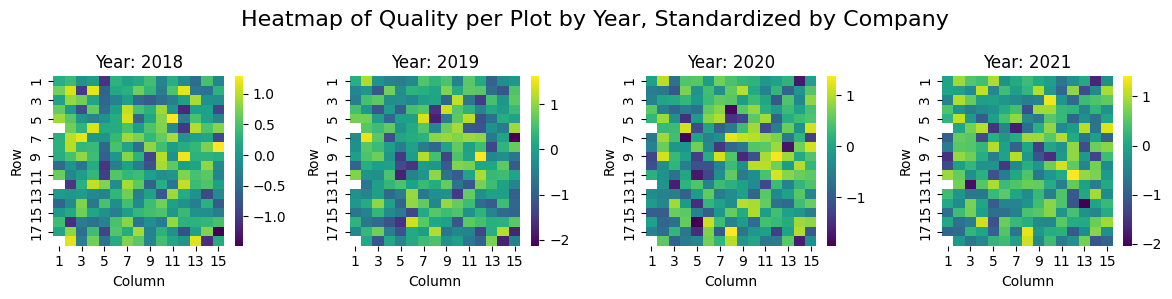

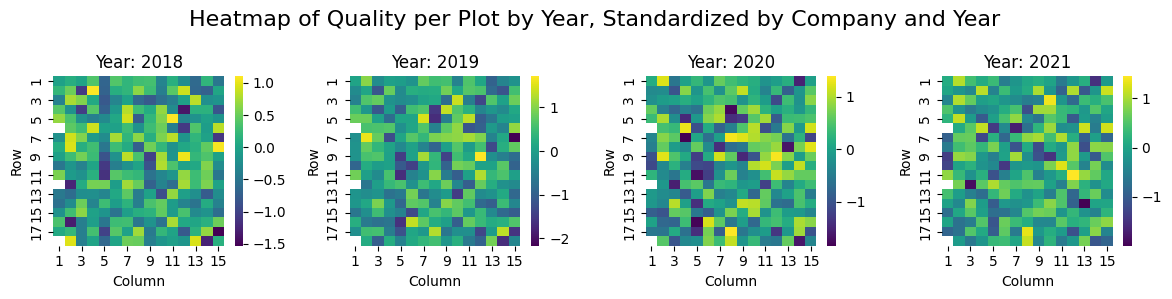

In [150]:
year_company_stats = df.groupby(['COMP', 'YEAR'])['QUALITY'].agg(['mean', 'std'])
def year_get_mean_std(row):
    company = row['COMP']
    time = row['YEAR']
    mean = year_company_stats.loc[(company, time), 'mean']
    std = year_company_stats.loc[(company, time), 'std']
    return (mean, std)
df['COMPYEAR_STANDARDIZED_QUALITY'] = (df['QUALITY'] - df.apply(year_get_mean_std, axis=1).map(lambda x: x[0])) / df['COMP'].map(company_stats['std'])

years = df['YEAR'].unique()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.suptitle('Heatmap of Quality per Plot by Year, Standardized by Company', fontsize=16)
for i, year in enumerate(years):
    year_data = df[df['YEAR'] == year]
    heatmap_df = year_data.pivot_table(values='STANDARDIZED_QUALITY', index='ROW', columns='COL', aggfunc='mean')
    ax = axes[i]
    sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(f'Year: {year}')
plt.tight_layout()
plt.show()
years = df['YEAR'].unique()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.suptitle('Heatmap of Quality per Plot by Year, Standardized by Company and Year', fontsize=16)
for i, year in enumerate(years):
    year_data = df[df['YEAR'] == year]
    heatmap_df = year_data.pivot_table(values='COMPYEAR_STANDARDIZED_QUALITY', index='ROW', columns='COL', aggfunc='mean')
    ax = axes[i]
    sns.heatmap(heatmap_df, cmap='viridis', annot=False, ax=ax)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(f'Year: {year}')
plt.tight_layout()
plt.show()

Lastly, we look at how the rating of a specific plots might vary over time.

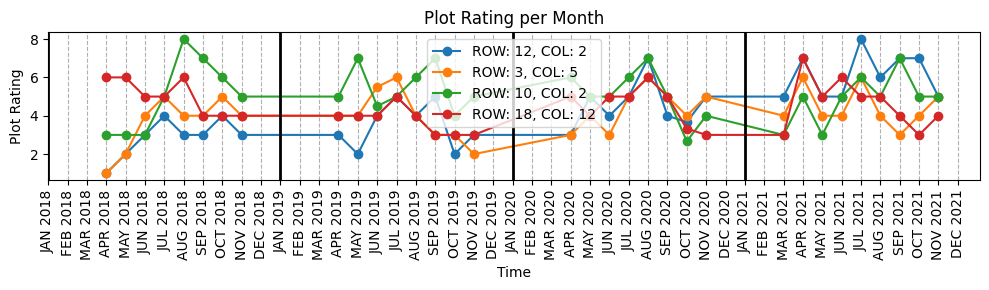

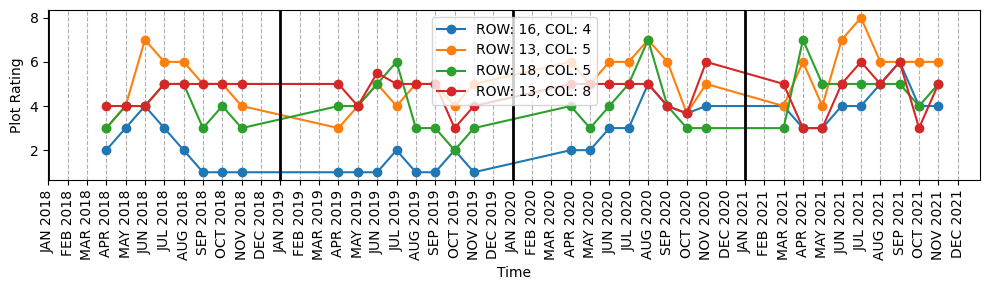

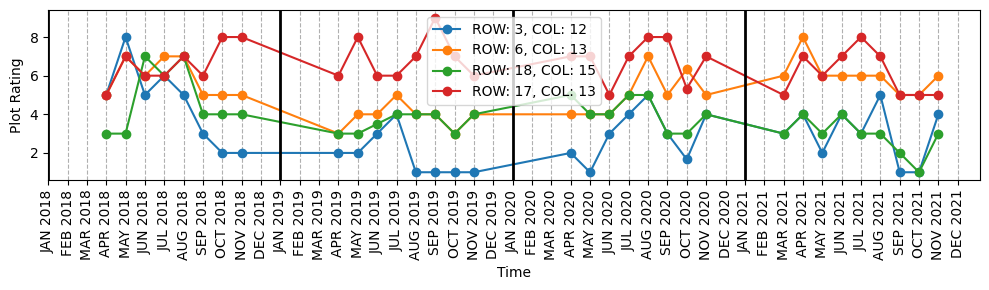

In [175]:
random_plot_ids = random.sample(list(df['PLT_ID'].unique()), 12)
mean_ratings = df.groupby(['PLT_ID','TIME'])['QUALITY'].mean()
for j in range(3):
  plt.figure(figsize=(10, 3))
  for plot in random_plot_ids[4*j:4*j+4]: # We only use the first few plots to make sure it's not too messy
      plot_data = df[df['PLT_ID'] == plot]
      row_value = plot_data['ROW'].values[0]
      col_value = plot_data['COL'].values[0]
      plt.plot(mean_ratings.loc[plot].index.get_level_values('TIME').tolist(), mean_ratings[mean_ratings.index.get_level_values('PLT_ID') == plot], label=f'ROW: {row_value}, COL: {col_value}',marker='o')
  plt.xlabel('Time')
  plt.ylabel('Plot Rating')
  if j==0: plt.title('Plot Rating per Month')
  plt.legend()
  plt.tight_layout()
  plt.xticks(range(48), [['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'][x%12]+" "+str(2018+x//12) for x in range(48)], rotation=90)  # Set text labels and properties.
  plt.gca().xaxis.grid(True, which='major', linestyle='--')
  for year in range(2018, 2022): plt.axvline(x=(year - 2018) * 12, color='black', linewidth=2)
  plt.tight_layout()
  plt.show()

#Analysis of Time and Raters

It is highly plausible that any given rater may have their own biases or styles of rating, but because there is usually only one rater each month, it is hard to compare the rating styles of different raters.

To try to analyze the effects of time independent of raters, we can try to account for the effect of different raters by considering the mean and standard deviation of their rating across different months (with some smoothing due to the small sample size).

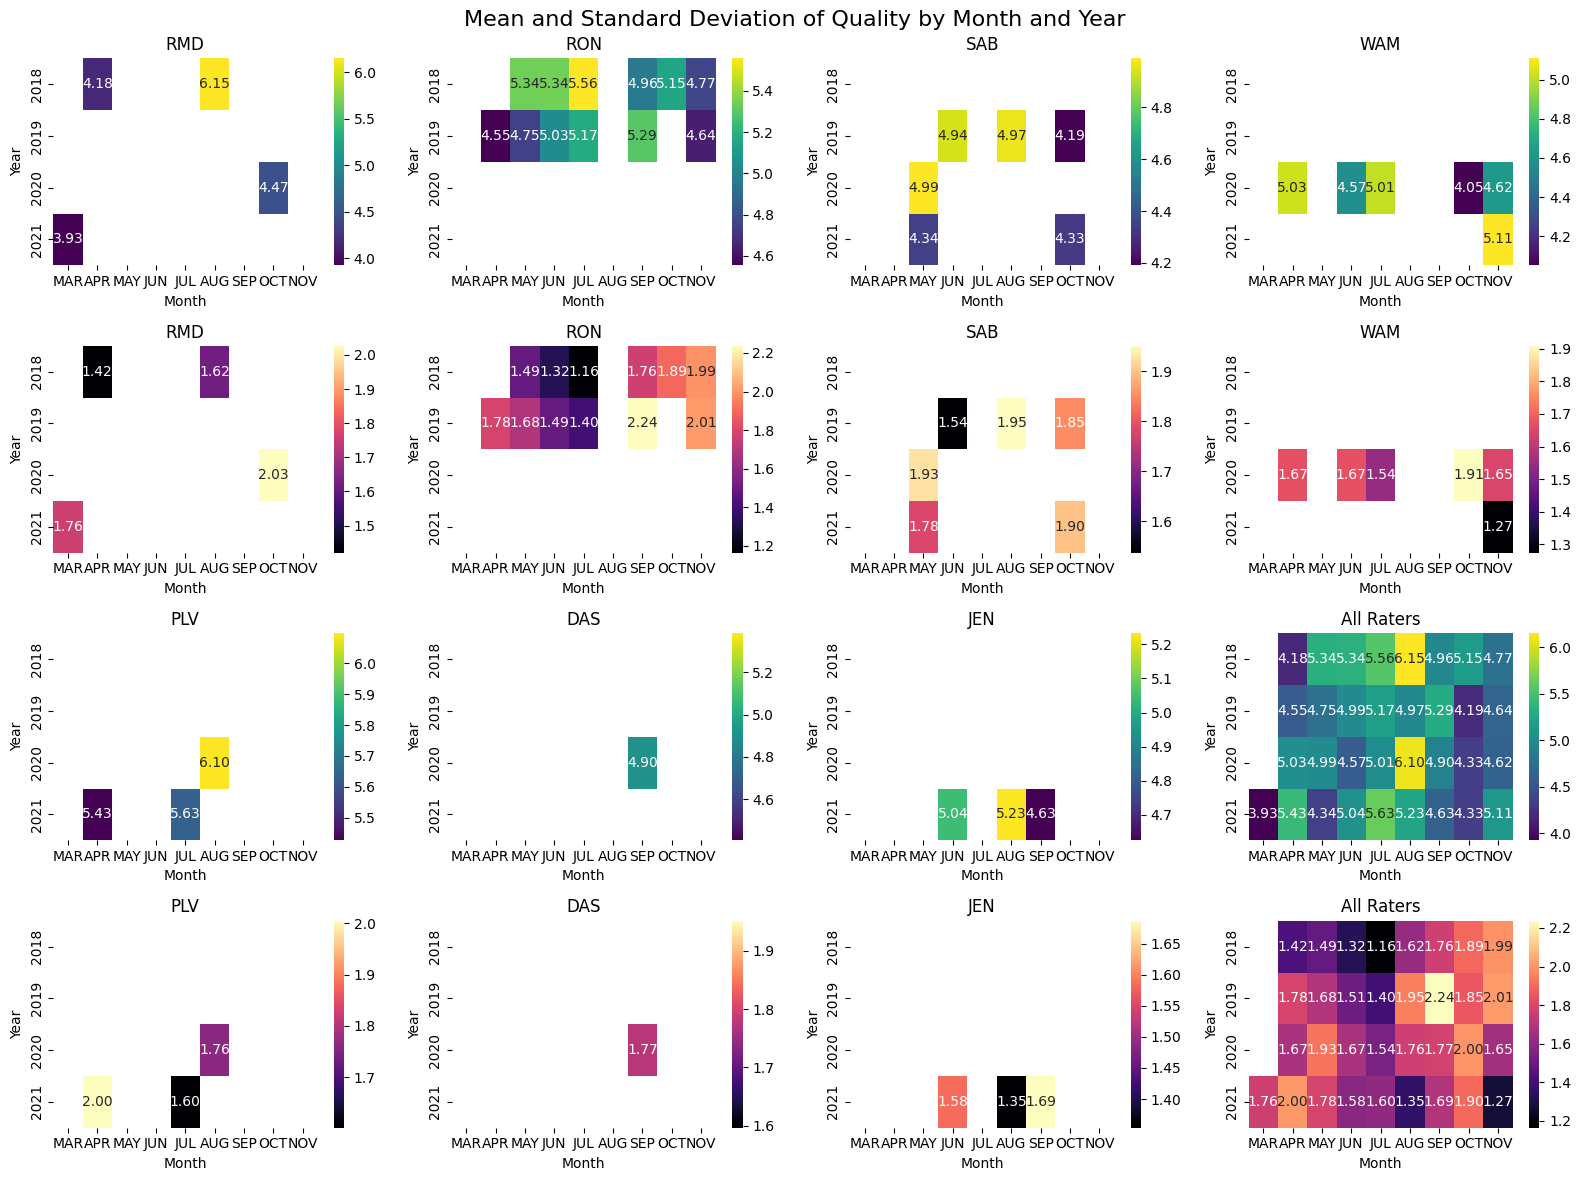

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
fig.suptitle('Mean and Standard Deviation of Quality by Month and Year', fontsize=16)
raters = df['RATER'].unique()
for j in [0,1]:
  for i, rater in enumerate(raters[4*j:3*j+4]):
    ax1 = axes[0+2*j, i]
    ax2 = axes[1+2*j, i]
    mean_df = df[df['RATER'] == rater].pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='mean')
    std_df = df[df['RATER'] == rater].pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='std')
    mean_df = mean_df.reindex(range(2, 11), axis=1)
    mean_df = mean_df.reindex(range(2018, 2022), axis=0)
    std_df = std_df.reindex(range(2, 11), axis=1)
    std_df = std_df.reindex(range(2018, 2022), axis=0)
    sns.heatmap(mean_df, cmap='viridis', annot=True, fmt='.2f', cbar=True, ax=ax1)
    ax1.set_xlabel('Month')
    ax1.set_xticks(ticks=np.arange(9)+0.5)
    ax1.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
    ax1.set_ylabel('Year')
    ax1.set_title(f'{rater}')
    sns.heatmap(std_df, cmap='magma', annot=True, fmt='.2f', cbar=True, ax=ax2)
    ax2.set_xlabel('Month')
    ax2.set_xticks(ticks=np.arange(9)+0.5)
    ax2.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
    ax2.set_ylabel('Year')
    ax2.set_title(f'{rater}')
mean_df = df.pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='mean')
std_df = df.pivot_table(values='QUALITY', index='YEAR', columns='MONTH_INT', aggfunc='std')
ax1 = axes[2,3]
ax2 = axes[3,3]
sns.heatmap(mean_df, cmap='viridis', annot=True, fmt='.2f', cbar=True, ax=ax1)
ax1.set_xlabel('Month')
ax1.set_xticks(ticks=np.arange(9)+0.5)
ax1.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
ax1.set_ylabel('Year')
ax1.set_title('All Raters')
sns.heatmap(std_df, cmap='magma', annot=True, fmt='.2f', cbar=True, ax=ax2)
ax2.set_xlabel('Month')
ax2.set_xticks(ticks=np.arange(9)+0.5)
ax2.set_xticklabels(['MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV'])
ax2.set_ylabel('Year')
ax2.set_title('All Raters')
plt.tight_layout()
plt.show()

#Exploratory Data Analysis Summary